# Clasificador polen (Telmu) a partir de una red pre-entrenada:

### GPU disponible:

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Modelo NASNetLarge:

In [1]:
import sys
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import  Convolution2D, MaxPooling2D, Dense, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K
from keras import applications
K.clear_session()

Using TensorFlow backend.


Este modelo contiene los pesos obtenidos con el pre-entrenamiento en ImageNet. Por defecto, establece una imagen de entrada de 331x331.

In [2]:
baseModel = applications.nasnet.NASNetLarge(weights="imagenet", include_top=False, input_shape=(331, 331, 3))#Cargamos la red
#baseModel.summary()#Muestra el contenido de la red.

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
NASNetLarge = applications.nasnet.NASNetLarge()
NASNetLarg.summary()#Red NASNet original con todas las capas

359751680/359748576 [==============================] - 554s 2us/step


NameError: name 'NASNetLarg' is not defined

In [5]:
NASNetLarge.summary()#Red NASNet original con todas las capas

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_261 (Activation)     (None, 165, 165, 96) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

activation_410 (Activation)     (None, 21, 21, 336)  0           separable_conv_1_bn_normal_right2
__________________________________________________________________________________________________
activation_412 (Activation)     (None, 21, 21, 336)  0           separable_conv_1_bn_normal_left5_
__________________________________________________________________________________________________
separable_conv_2_normal_left1_1 (None, 21, 21, 336)  121296      activation_404[0][0]             
__________________________________________________________________________________________________
separable_conv_2_normal_right1_ (None, 21, 21, 336)  115920      activation_406[0][0]             
__________________________________________________________________________________________________
separable_conv_2_normal_left2_1 (None, 21, 21, 336)  121296      activation_408[0][0]             
__________________________________________________________________________________________________
separable_

### Modificación de la última capa:

Se diseña la capa de salida para realizar la clasificación. Constará de:

Capa GlobalAveragePooling2D.

Capa tipo Dense de 1000 neuronas y activación rectificador (relu)

In [3]:
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(662, activation="relu")(headModel)
headModel = Dropout(0.35)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# add a global spatial average pooling layer
#x = InceptionResNetV2.output
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(800, activation='relu')(x)
#To reduce overfitting...
#x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 3 classes
#predictions = Dense(2, activation='softmax')(x)
#model = Model(inputs=InceptionResNetV2.input, outputs=predictions)

model = Model(inputs=baseModel.input, outputs=headModel)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Congelación de capas:

Se ha cargado la red pre-entrenada NASNetLarge, con los pesos de Imagenet. De esta forma las capas convolucionales y pooling que la forman actuarán como diferenciadoras de características, que serán usadas por la capa final que se ha incluido para realizar la clasificación.

Por tanto, se va a usar una red que ya ha 'aprendido' a clasificar en otros problemas, y se va a adaptar para el problema que aquí se trata (TRANSFER LEARNING).

Es por esto que no es necesario entrenar todas las capas de la red, y solo se entrenarán las 3 capas que se han añadido, congelando las demás.

In [4]:
#for layer in model.layers[:780]:
#   layer.trainable = False
#for layer in model.layers[780:]:
#   layer.trainable = True
for layer in baseModel.layers:
    layer.trainable = False

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 165, 165, 96) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

separable_conv_1_bn_normal_righ (None, 21, 21, 336)  1344        separable_conv_1_normal_right1_11
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 21, 21, 336)  1344        separable_conv_1_normal_left2_11[
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 21, 21, 336)  1344        separable_conv_1_normal_right2_11
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 21, 21, 336)  1344        separable_conv_1_normal_left5_11[
__________________________________________________________________________________________________
activation_156 (Activation)     (None, 21, 21, 336)  0           separable_conv_1_bn_normal_left1_
__________________________________________________________________________________________________
activation

separable_conv_1_bn_normal_righ (None, 11, 11, 672)  2688        separable_conv_1_normal_right1_17
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 11, 11, 672)  2688        separable_conv_1_normal_left2_17[
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 11, 11, 672)  2688        separable_conv_1_normal_right2_17
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 11, 11, 672)  2688        separable_conv_1_normal_left5_17[
__________________________________________________________________________________________________
activation_239 (Activation)     (None, 11, 11, 672)  0           separable_conv_1_bn_normal_left1_
__________________________________________________________________________________________________
activation

### Tratamiento de las imágenes:

Se necesita adaptar el conjunto de imágenes para poder ser tratado por el modelo. Para ello se van a usar las funciones flow_from_directory() y ImageDataGenerator().

In [5]:
#Se almacenan en variables los directorios en los que se encuentran las imágenes
data_entrenamiento = './data_polen/entrenamiento'
data_validacion = './data_polen/validacion'

#Parámetros importantes:
epocas=80
longitud, altura = 331, 331
batch_size = 16 #Imágenes a procesar en cada paso
pasos = 10
clases = 3
lr = 1e-4 #Learning rate
momentum = 0.9

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')

Con la función flow_from_directory() se pre-procesan las imágenes que se encuentran en los directorios previamente declarados. Además se le puede pasar como parámetros el tamaño al que se redimensionan las imágenes, o el algoritmo de interpolación.

keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

Gracias a la función ImageDataGenerator() se aplica al set de entrenamiento mecanismos de DATA ARGUMENTATION como inclinar, hacer zoom o invertir las imágenes.

In [6]:
###Procesamiento del conjunto de entrenamieto:
entrenamiento_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, #Inclina las imágenes
    zoom_range=0.2, #Zoom a algunas imágenes
    horizontal_flip=True) #Invierte imágenes para distinguir direcionalidad

###Procesamiento del conjunto de validación:
#No es necesario inclinar, hacer zoom ni invertir las imágenes.
test_datagen = ImageDataGenerator(rescale=1. / 255)

###Generación del conjunto de entrenamieto:
entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical') #Se busca una clasificación categórica

###Generación del conjunto de validación:
validacion_generador = test_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')

print(entrenamiento_generador.class_indices)

Found 180 images belonging to 3 classes.
Found 54 images belonging to 3 classes.
{'Muestra1': 0, 'Muestra10': 1, 'Muestra6': 2}


### Definición del modelo CNN: función pérdida y optimizador:

In [7]:
opt = optimizers.SGD(lr=lr, momentum=momentum)
model.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

### Entrenamiento del modelo:

fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

In [8]:
H = model.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=len(entrenamiento_generador),
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=len(validacion_generador))

Instructions for updating:
Use tf.cast instead.
Epoch 1/80
12/12 [==============================] - 56s 5s/step - loss: 1.1687 - acc: 0.2827 - val_loss: 1.1386 - val_acc: 0.2963
Epoch 2/80
12/12 [==============================] - 34s 3s/step - loss: 1.1409 - acc: 0.3521 - val_loss: 1.1342 - val_acc: 0.2963
Epoch 3/80
12/12 [==============================] - 35s 3s/step - loss: 1.1126 - acc: 0.3599 - val_loss: 1.1300 - val_acc: 0.2963
Epoch 4/80
12/12 [==============================] - 35s 3s/step - loss: 1.0815 - acc: 0.4097 - val_loss: 1.1276 - val_acc: 0.2963
Epoch 5/80
12/12 [==============================] - 35s 3s/step - loss: 1.0544 - acc: 0.4464 - val_loss: 1.1233 - val_acc: 0.2778
Epoch 6/80
12/12 [==============================] - 35s 3s/step - loss: 1.0617 - acc: 0.4738 - val_loss: 1.1183 - val_acc: 0.2407
Epoch 7/80
12/12 [==============================] - 35s 3s/step - loss: 1.0465 - acc: 0.4332 - val_loss: 1.1167 - val_acc: 0.2778
Epoch 8/80
12/12 [========================

12/12 [==============================] - 35s 3s/step - loss: 0.6558 - acc: 0.8272 - val_loss: 1.0028 - val_acc: 0.4815
Epoch 62/80
12/12 [==============================] - 34s 3s/step - loss: 0.6418 - acc: 0.8233 - val_loss: 1.0030 - val_acc: 0.4815
Epoch 63/80
12/12 [==============================] - 34s 3s/step - loss: 0.6317 - acc: 0.8377 - val_loss: 1.0068 - val_acc: 0.4630
Epoch 64/80
12/12 [==============================] - 34s 3s/step - loss: 0.6324 - acc: 0.8285 - val_loss: 1.0089 - val_acc: 0.4630
Epoch 65/80
12/12 [==============================] - 34s 3s/step - loss: 0.6579 - acc: 0.8011 - val_loss: 1.0113 - val_acc: 0.5000
Epoch 66/80
12/12 [==============================] - 35s 3s/step - loss: 0.6581 - acc: 0.8076 - val_loss: 1.0081 - val_acc: 0.4815
Epoch 67/80
12/12 [==============================] - 34s 3s/step - loss: 0.6150 - acc: 0.8390 - val_loss: 1.0008 - val_acc: 0.5000
Epoch 68/80
12/12 [==============================] - 34s 3s/step - loss: 0.6541 - acc: 0.7932 -

### Gráficas con resultados del entrenamiento batch_size 16:

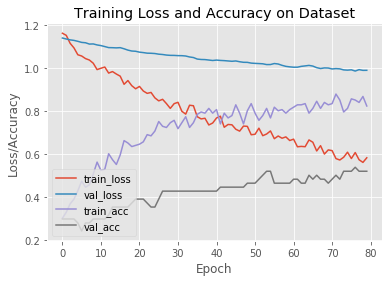

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
N = epocas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")#Se guarda la gráfica en disco

### Cálculo de la función pérdida:

El método evaluate_generator(generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0) se encarga de calcular la función de pérdida dados unos datos de entrada y el nivel de aciertos del modelo para una muestra dada.

In [11]:
score = model.evaluate_generator(validacion_generador, steps=pasos, verbose=1)
print('Test accuracy:', score[1])
print('Loss:', score[0])

18/18 [==============================] - 37s 2s/step
Test accuracy: 0.5126050437698845
Loss: 0.9968203030714468


### Guardar el modelo entrenado:

Para no tener que entrenar la red neuronal creada cada vez que se quiera usar, se crea un archivo donde se guarda el modelo creado, y otro donde se guardan los pesos obtenidos para las neuronas después del entranmiento.

In [12]:
import os 
dir = './NASNet_3class/'
if not os.path.exists(dir):
    os.mkdir(dir)
model.save('./NASNet_3class/modelo_NASNet_3class.h5')#Se guarda la estructura de la cnn
model.save_weights('./NASNet_3class/pesos_NASNet_3class.h5')#Se guardan los pesos de la cnn

### Pruebas de clasificación:

In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

La función load_image() transforma de forma interna las imágenes, tomando como argumento las dimensiones que admiten las arquitecturas implementadas y un método de interpolación. Se recomienda usar métodos de interpolación como bicubic o lanczos, frente a nearest que viene por defecto.

In [ ]:
###Función predicción:
def predict(file):
  x = load_img(file, target_size=(altura, longitud))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0) #Zero mean pre-processing, normalize data.
  array = model.predict(x)
  print(array)  
  result = array[0]
  print(result)
  answer = np.argmax(result)
  print(answer)  
  if answer == 0:
    print("pred: M1")
  elif answer == 1:
    print("pred: M10")
  elif answer == 2:
    print("pred: M6")
  return answer

In [ ]:
x = load_img('graminea1.jpg', target_size=(altura, longitud))
x = img_to_array(x)
x = np.expand_dims(x, axis=0)
model.predict(x)